In [1]:
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Preprocessing

In [3]:
data_path = '/kaggle/input/guitar-chords/Guitar_Only'
chords = ['a', 'am', 'bm', 'c', 'd', 'dm', 'e', 'em', 'f', 'g']

# Function to extract HPCP features
def extract_hpcp(file_path):
    y, sr = librosa.load(file_path)
    hpcp = librosa.feature.chroma_stft(y=y, sr=sr)
                                         
    return np.mean(hpcp, axis = 1)

# Preprocess dataset
data = []
labels = []

for chord in chords:
    chord_path = os.path.join(data_path, chord)
    for file in os.listdir(chord_path):
        if file.endswith('.wav'):
            file_path = os.path.join(chord_path, file)
            y, sr = librosa.load(file_path)
            break_pt = round(len(y) * (np.random.randint(1,4) / 4))
            y1 = librosa.feature.chroma_stft(y=y[:break_pt])
            y2 = librosa.feature.chroma_stft(y=y[break_pt:])            
            data.append(np.mean(y1, axis = 1))
            labels.append(chord)
            data.append(np.mean(y2, axis = 1))
            labels.append(chord)

data = np.array(data)
labels = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split data
X_train, X_test, y_train, y_test = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)

sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

# Model Building

In [4]:
import pickle
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Train SVM model
model = SVC(kernel='linear', C=100, probability = True)
model.fit(X_train, y_train)

# Save the trained model
with open('chord_svm_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Classification report
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print("Classification report:")
print(report)

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97        98
           1       0.93      0.96      0.95        73
           2       0.98      0.99      0.98        88
           3       0.98      0.98      0.98        89
           4       0.82      0.92      0.87        74
           5       0.94      0.80      0.87        82
           6       0.96      0.94      0.95        78
           7       0.94      0.94      0.94        64
           8       0.94      0.98      0.96        81
           9       1.00      0.97      0.99        73

    accuracy                           0.95       800
   macro avg       0.95      0.94      0.94       800
weighted avg       0.95      0.95      0.95       800



# Grid Search

In [5]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [6]:
parameters = {'kernel': ['linear', 'rbf'], 'C':[0.1,1,10,100]}
svc = SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']})

In [7]:
y_pred = clf.predict(X_test)

In [8]:
clf.get_params()

{'cv': None,
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__break_ties': False,
 'estimator__cache_size': 200,
 'estimator__class_weight': None,
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': 'ovr',
 'estimator__degree': 3,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__probability': False,
 'estimator__random_state': None,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'estimator': SVC(),
 'n_jobs': None,
 'param_grid': {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10, 100]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

In [9]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        98
           1       0.93      0.96      0.95        73
           2       0.97      0.99      0.98        88
           3       0.99      0.99      0.99        89
           4       0.83      0.92      0.87        74
           5       0.96      0.87      0.91        82
           6       0.99      0.92      0.95        78
           7       0.94      0.94      0.94        64
           8       0.96      0.98      0.97        81
           9       0.97      0.95      0.96        73

    accuracy                           0.95       800
   macro avg       0.95      0.95      0.95       800
weighted avg       0.95      0.95      0.95       800



# Prediction on Actual Songs

In [10]:
import numpy as np
import librosa
import pickle
import warnings
warnings.filterwarnings('ignore')

def predict_chords(audio_file, model, label_encoder, segment_length=0.5):
    y, sr = librosa.load(audio_file)
    duration = librosa.get_duration(y=y, sr=sr)
    print(duration)
    chords_pred = []
    
    # Convert segment_length to frames
    segment_length_frames = int(segment_length * sr)
    
    # Loop through the audio in segments
    for start in np.arange(0, duration, segment_length):
        end = min(start + segment_length, duration)
        
        # Convert start and end times to frame indices
        start_frame = int(start * sr)
        end_frame = int(end * sr)
        
        segment = y[start_frame:end_frame]

        # Extract features
        chroma = librosa.feature.chroma_stft(y=segment, sr=sr)
        features = np.mean(chroma, axis=1).reshape(1,-1)
        
        # Get prediction probabilities
        probas = model.predict_proba(features)[0]
        
        # Get all chords with probability above the threshold
        best_idx = np.argmax(probas)
        best_chord = label_encoder.inverse_transform([best_idx])[0]
        chords_pred.append(best_chord)
    
    return chords_pred

# Load the model and label encoder
with open('chord_svm_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Predict chords
audio_file = '/kaggle/input/about-a-girl/about a girl.wav'
predicted_chords = predict_chords(audio_file, model, label_encoder, segment_length=0.5)

print(f'Predicted chords: {predicted_chords}')


15.346122448979592
Predicted chords: ['em', 'em', 'em', 'g', 'em', 'em', 'em', 'g', 'em', 'em', 'g', 'g', 'em', 'em', 'g', 'g', 'em', 'em', 'g', 'em', 'em', 'em', 'g', 'em', 'em', 'em', 'g', 'em', 'em', 'g', 'g']


In [11]:
unique_progression = []
for i in predicted_chords:
    if len(unique_progression) == 0:
        unique_progression.append(i)
    else:
        if unique_progression[-1] == str(i):
            continue
        else:
            unique_progression.append(i)
            
print(unique_progression)

['em', 'g', 'em', 'g', 'em', 'g', 'em', 'g', 'em', 'g', 'em', 'g', 'em', 'g', 'em', 'g']


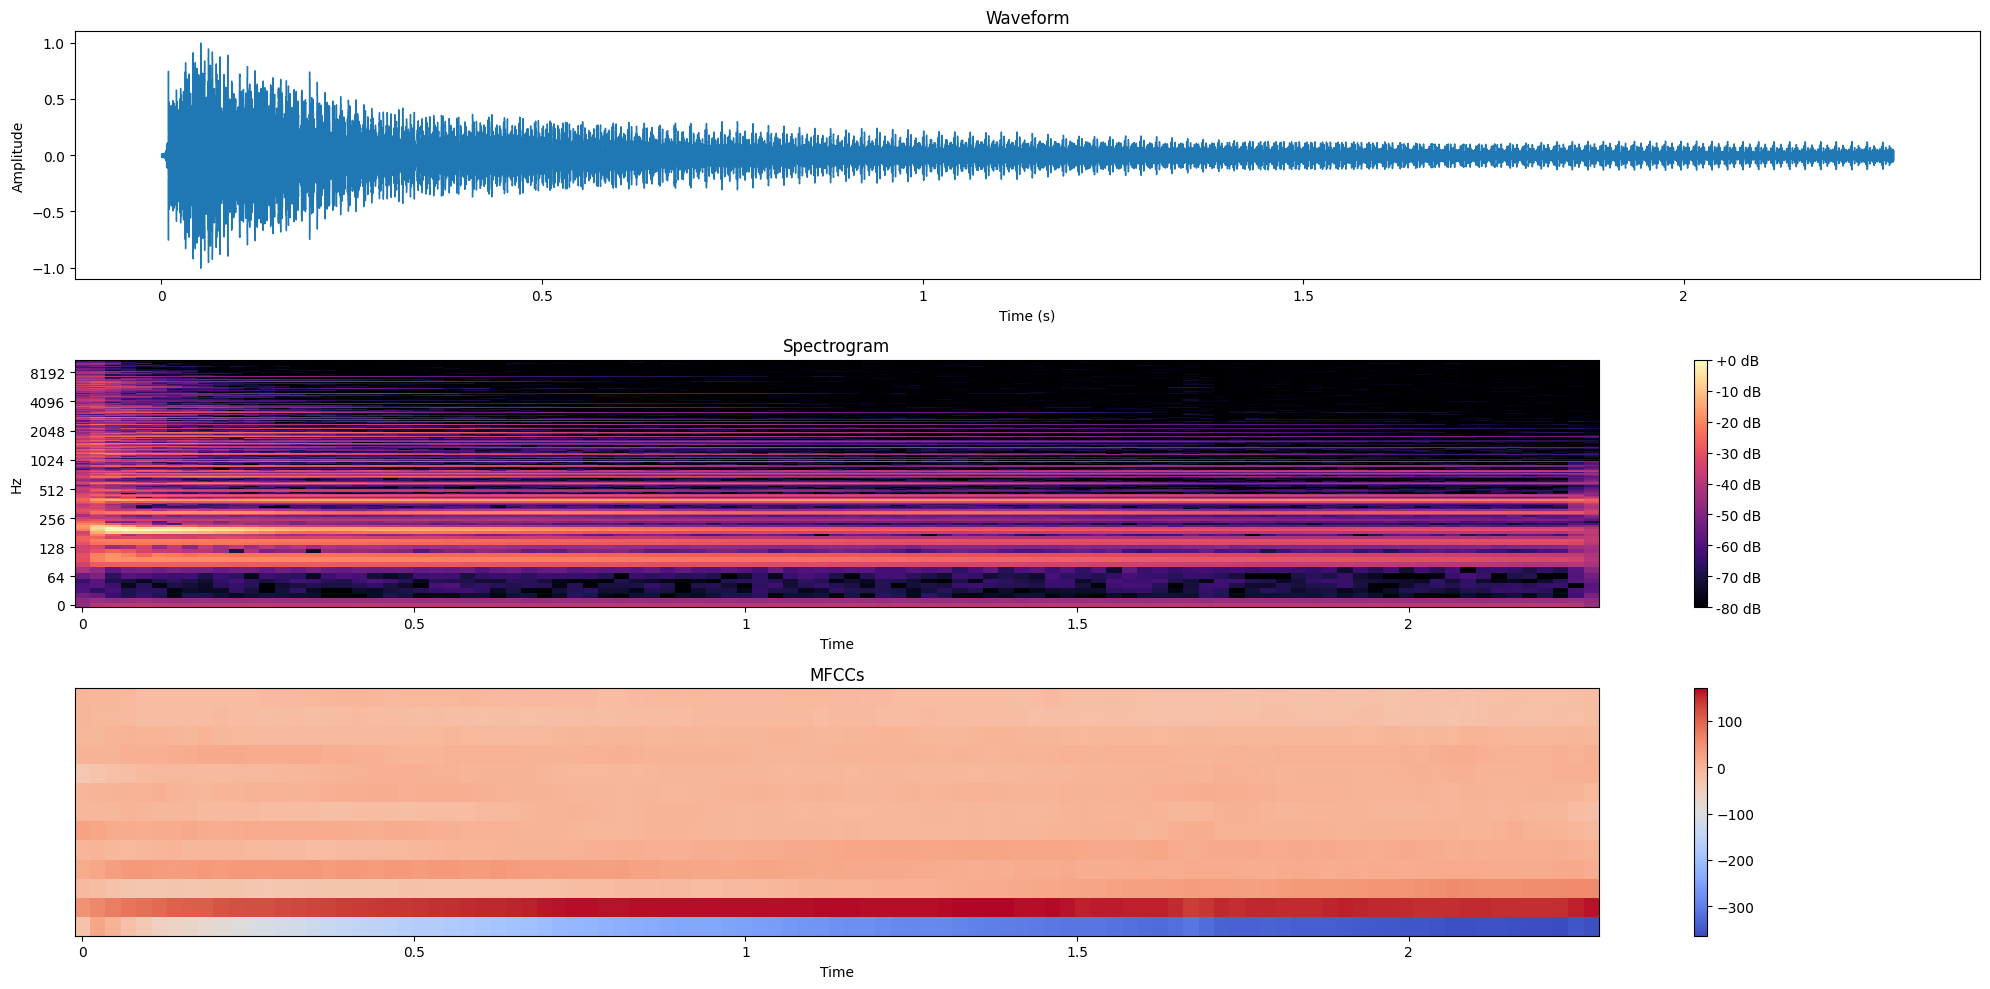

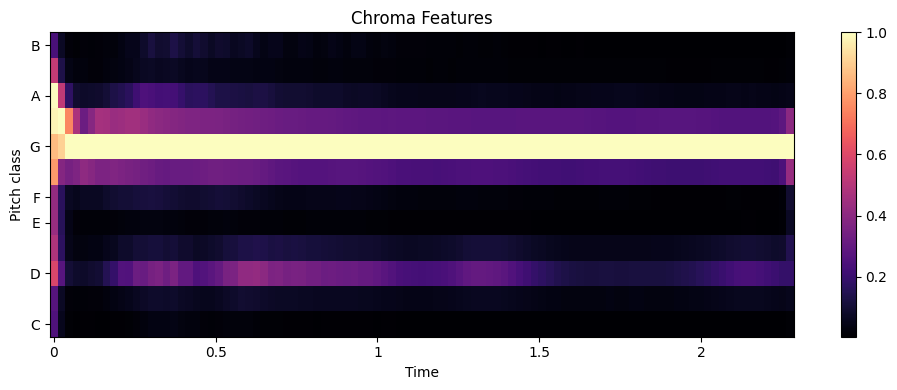

In [12]:
import matplotlib.pyplot as plt
# # Visualization of a single audio file for example
# #example_file = os.path.join(base_dir, '/kaggle/input/guitar-chords-v3/Training', '/kaggle/input/guitar-chords-v3/Training/Bb', 'Bb_AcusticPlug12_4.wav')  # Replace with an actual example file path
# example_file = os.path.join('/kaggle/input/test111', '/kaggle/input/test111/coniferous-forest-142569.wav')  # Replace with an actual example file path

# Load the example audio file
# y, sr = librosa.load(example_file, sr=44100, mono=True)

# Normalize the audio signal
y = y / np.max(np.abs(y))

# Extract features
stft = librosa.stft(y)
stft_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
chroma = librosa.feature.chroma_stft(y=y, sr=sr)

# Plot waveform
plt.figure(figsize=(20, 10))
plt.subplot(3, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Plot spectrogram
plt.subplot(3, 1, 2)
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')

# Plot MFCCs
plt.subplot(3, 1, 3)
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar()
plt.title('MFCCs')

plt.tight_layout()
plt.show()

# Plot Chroma features
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.title('Chroma Features')
plt.tight_layout()
plt.show()


# Space removal in betn and at the end

In [13]:
import librosa

In [14]:
y, sr = librosa.load('/kaggle/input/guitar-chords-v3/Test/C/C_AcusticPlug28_2.wav')

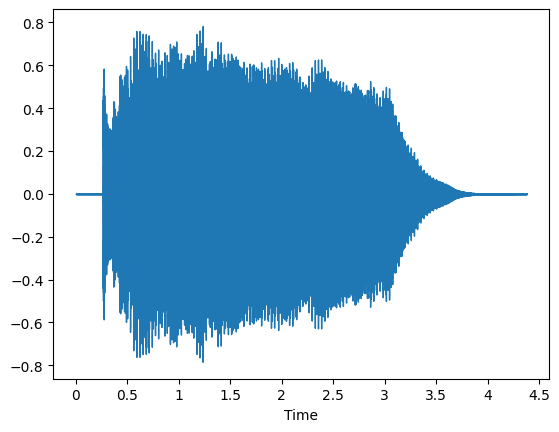

In [15]:
librosa.display.waveshow(y, sr=sr)

In [16]:
def space_removal(y):
    y = list(y)
    for i,j in enumerate(y):
        if abs(j) >= 0.2:
            y1 = [k for k in y[:i] if abs(k) >= 0.01] + y[i:]
            break
    for i,j in enumerate(y1[::-1]):
        if abs(j) >= 0.2:
            y2 = [k for k in y1[::-1][:i] if abs(k) >= 0.01] + y1[::-1][i:]
            break
    return np.array(y2[::-1])

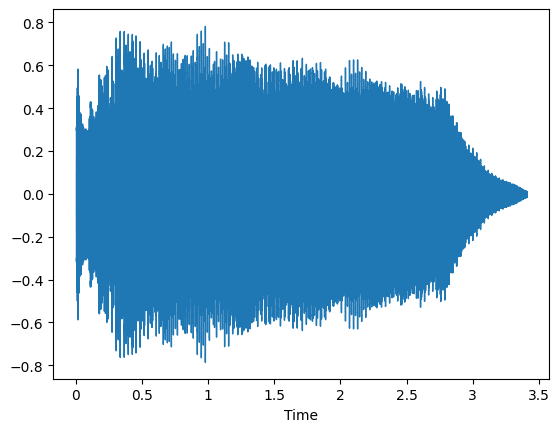

In [17]:
y_new = space_removal(y)
librosa.display.waveshow(y_new, sr=sr)

In [18]:
import numpy as np
import matplotlib.pyplot as plt

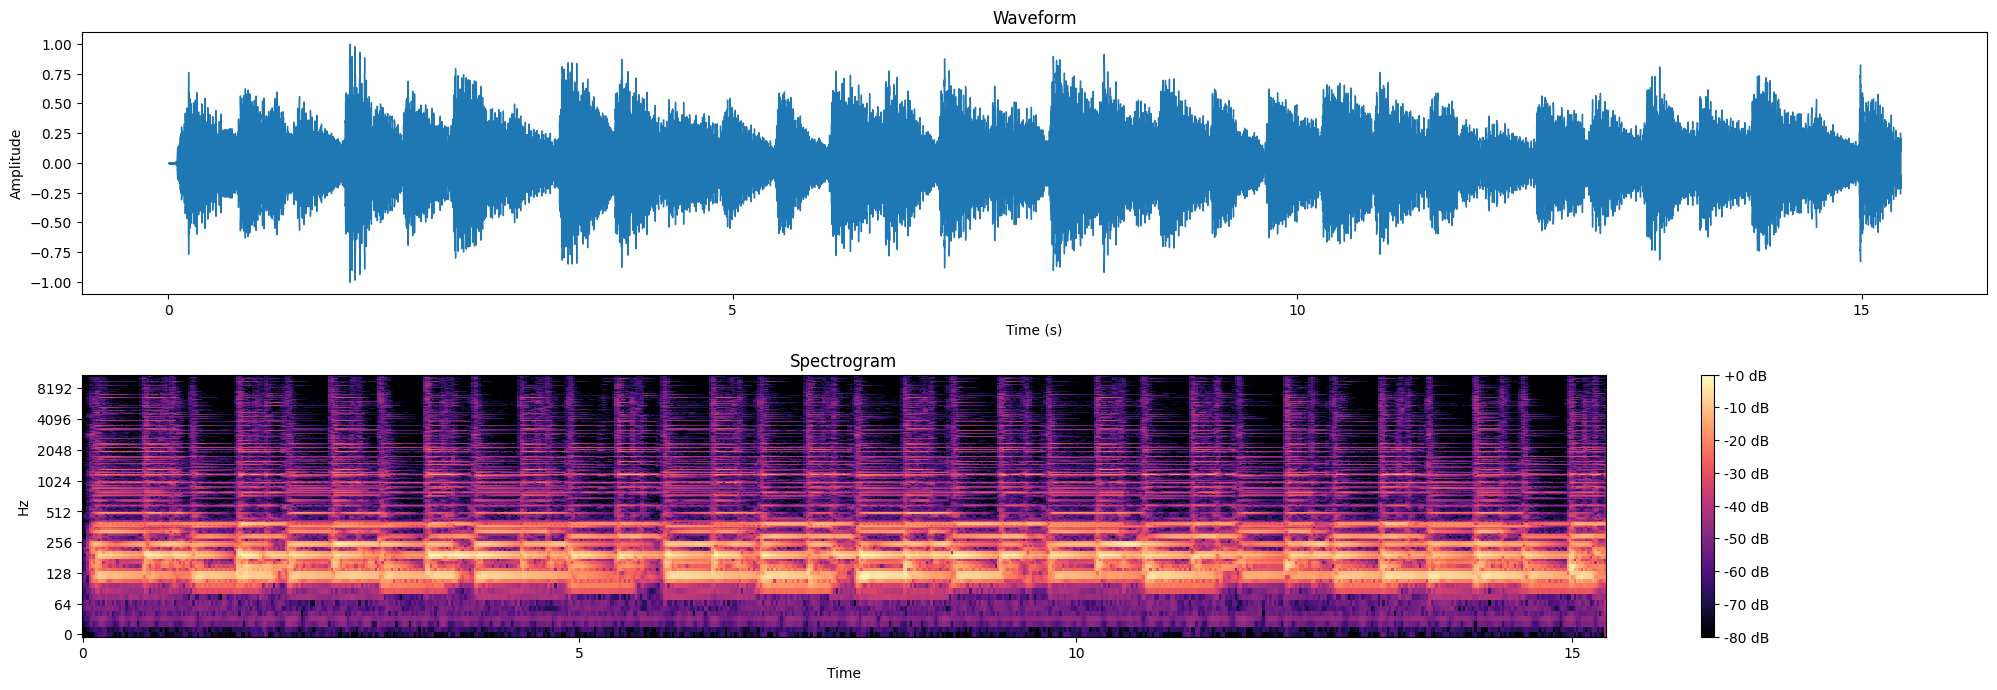

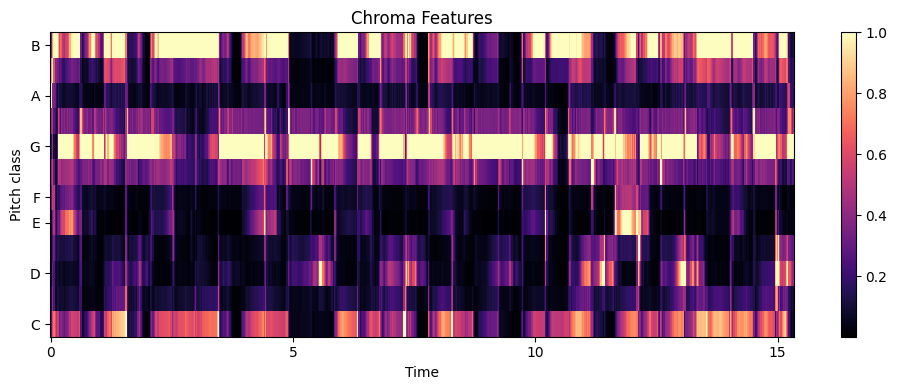

In [19]:
y, sr = librosa.load('/kaggle/input/about-a-girl/about a girl.wav')

# Normalize the audio signal
y = y / np.max(np.abs(y))

# Extract features
stft = librosa.stft(y)
stft_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
chroma = librosa.feature.chroma_stft(y=y, sr=sr)

# Plot waveform
plt.figure(figsize=(20, 10))
plt.subplot(3, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Plot spectrogram
plt.subplot(3, 1, 2)
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')

plt.tight_layout()
plt.show()

# Plot Chroma features
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.title('Chroma Features')
plt.tight_layout()
plt.show()